<a href="https://colab.research.google.com/github/Ashuku001/ML_NLP/blob/main/Ch4_MultiLingual_Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# looking at the dataset


In [2]:
!pip install datasets
!pip install transformers
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 511.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=7877e3f6b4fbeac153ae50415d73eba8f33b5b8d542148820eb10a2a8f86dbc0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed

In [2]:
from datasets import get_dataset_config_names
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"(XTREME has {len(xtreme_subsets)} configurations)")

(XTREME has 183 configurations)


In [3]:
# narrow the search by looking for the congiguration starting with PAN
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [4]:
from datasets import load_dataset
load_dataset("xtreme", name="PAN-X.de")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [5]:
from collections import defaultdict
from datasets import DatasetDict
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
  # load monolingual corpus
  ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
  # shuffle and downsample each split according to spoken proportion
  for split in ds:
    panx_ch[lang][split] = (
        ds[split].shuffle(seed=0).select(range(int(frac * ds[split].num_rows)))
    )

In [6]:
# to check how many samples we have per language in the training sets
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [7]:
# inspect one examples in the German corpus
element = panx_ch["de"]["train"][0]
for key, value in element.items():
  print(f"{key}: {value}")

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


In [8]:
# dataset has a featuers attribute specifying the underlying
# data types associated with each column
for key, value in panx_ch["de"]["train"].features.items():
  print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [9]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)


we can use Classlabel.intstr() to create a new column in our training set with class names for each tag. We use the map() to return a dict with the key corresponding to the new column name and the value as a list of class names


In [10]:
# setting our tags into human-readable format
def create_tag_names(batch):
  return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

panx_de = panx_ch["de"].map(create_tag_names)

In [11]:
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]], ["tokens", "tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [12]:
# check if we have any unsual imbalance in the tags
from collections import Counter
split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset["ner_tags_str"]:
    for tag in row:
      if tag.startswith("B"):
        tag_type = tag.split("-")[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


It looks good the distributions of the PER, LOC and ORG frequencies are roughly the same for each split so the validation and the test sets should provide a good measuer of our NER tagger's ability to generalize.

# Multilingual Transformers


In [13]:
from transformers import AutoTokenizer
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [14]:
text = "Jack Sparrow loves New Your!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [15]:
bert_tokens

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'Your', '!', '[SEP]']

In [16]:
xlmr_tokens

['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁Your', '!', '</s>']

In [17]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New Your!</s>'

In [18]:
from transformers.models.xlm_roberta.modeling_xlm_roberta import XLMRobertaConfig
# A custom model for token classification
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  config_class = XLMRobertaConfig # config file for XMLR file(contains settings)

  def __init__(self, config):
    # handles the initialization or loading of pretrained weights
    super().__init__(config) # call initialization function of RobertaPretrained Model
    self.num_labels = config.num_labels
    # load model body add_pooling_layer to false ensure all hidden layers are returned
    # and not only the one associalted with [CLS]
    self.roberta = RobertaModel(config, add_pooling_layer=False)
    # set up token classification head(attacj a dropout and a Feed-forward layer)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    # load and initialize weights from RobertaPretrainedModel
    self.init_weights()

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None, **kwargs):
    # use model body to get encoder representations
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                           token_type_ids=token_type_ids, **kwargs ) # initialize the body
    # apply classifier to encoder representations
    sequence_output = self.dropout(outputs[0]) # dropout layer
    logits = self.classifier(sequence_output) # the linear layer
    # calculate losses
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    # return model output object
    return TokenClassifierOutput(loss=loss, logits=logits,
                                 hidden_states=outputs.hidden_states,
                                 attentions=outputs.attentions)

In [19]:
# Loading a custom model
# the info from tags variable
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [20]:
# store the mappings and tag.num_class in AutoConfig
from transformers import AutoConfig
# load the configuration file with the parameters we want to alter
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label = index2tag,
                                         label2id = tag2index)

In [21]:
# loading the model weights as usual with a custom config
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # a GPu or CPU
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,
                          config=xlmr_config).to(device)) # load model to the device with the custom config


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Check if we have initialized the tokenizer and model correctly
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁Your,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,14804,38,2


In [24]:
# yes they were initialized correctly
# pass the inputs to the model and extract the predictions by taking the argmax to get most likely class per token
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")#[batch_size, num_tokens, num_tags]

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


In [25]:
# enumarate over the sequence and see what the pretrained model predicts
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁Your,!,</s>
Tags,O,O,O,O,O,O,O,O,O,O


In [26]:
# We wrap the preceding steps into a helper function
def tag_text(text, tags, model, tokenizer):
  # Get token with special characters
  tokens = tokenizer(text).tokens()
  # encode the sequence(text) into IDs and put into the device
  input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
  # Get predictions as distribution over 7 possible classes
  outputs = model(input_ids)[0]
  # Take argmax to get the most likely class per token
  predictions = torch.argmax(outputs, dim=2)
  # Convert to DataFrame
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

In [27]:
# TOkenizing texts for NER  for the whole dataset
# first collecting the words and tags as ordinary lists
words, labels = de_example["tokens"], de_example["ner_tags"]
labels

[0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]

In [28]:
# tokenize each words an use is_split_into_words arg to tell the tokenizer that
# our input sequence has already been split into words
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


from that we see tokenizer splits Einwohnern into two subwords since we are want __Einwohner to be associated with B-LOC label. we need a way to mask the subwords representations after the first subword

In [29]:
# tokenized_input a class with word_ids()
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word Ids"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word Ids,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Here we see that word_ids has mapped each subword to the corresponding index in the words sequence.

In [30]:
# we set -100 as label for the special tokens and subwords we wish to mask during training
previous_word_idx = None
label_ids = []
for word_idx in word_ids:
  # word_idx correspond to <s> or to a subword for the sameword
  if word_idx is None or word_idx == previous_word_idx:
    label_ids.append(-100) # set to -100
  elif word_idx != previous_word_idx: # subword does not belong to same word
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx # cache the word_idx

# convert index to tag. but if is <s> or subword of a word with previous also a subword of same word label it as IGN
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


We use -100 as the ID to mask subword representations since PyTorch the cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute called ignore_index whose value is -100. This index is ignored during training so we can use it to ignore the tokens associated with consecutive subwords

In [32]:
# we wrap the previous logic into one function
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                    is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

In [33]:
# now we have ingredients to encode each split(writing a function to iterate over)
def encode_panx_dataset(corpus):
  """apply to a DatasetDict object to get an encoded Dataset object per split"""
  return corpus.map(tokenize_and_align_labels, batched=True,
                    remove_columns=["langs", "ner_tags", "tokens"])


In [34]:
# encoding our German corpus
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [35]:
# Performance measures
from seqeval.metrics import classification_report
y_true = [["O", "O","O","B-MISC", "I-MISC","I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O","B-MISC", "I-MISC","I-MISC","I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [36]:
# a function that takes outputs of a model and convert them into a list that seqeval expects
import numpy as np
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])

    labels_list.append(example_labels)
    preds_list.append(example_preds)

  return preds_list, labels_list

In [37]:
from huggingface_hub import notebook_login
notebook_login()

In [38]:
!pip install -U accelerate==0.20.3
import accelerate
accelerate.__version__

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

'0.20.3'

In [39]:
# define the training attributes in the TrainingArguments class
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True
)

In [40]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [41]:
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
  eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

In [43]:
def model_init():
  return (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

In [44]:
from transformers import Trainer
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/Ashuku/xlm-roberta-base-finetuned-panx-de into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/1.03G [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.87k/3.87k [00:00<?, ?B/s]

Download file runs/Aug15_06-11-56_0f7f5431b79c/events.out.tfevents.1692081690.0f7f5431b79c.1836.0: 100%|######…

Download file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

Clean file training_args.bin:  26%|##5       | 1.00k/3.87k [00:00<?, ?B/s]

Clean file runs/Aug15_06-11-56_0f7f5431b79c/events.out.tfevents.1692081690.0f7f5431b79c.1836.0:  17%|#6       …

Clean file tokenizer.json:   0%|          | 1.00k/16.3M [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/1.03G [00:00<?, ?B/s]

In [ ]:
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.262500,0.154871,0.822959
2,0.127300,0.136631,0.848574


In [45]:
from transformers import pipeline
model_id = "Ashuku/xlm-roberta-base-finetuned-panx-de"
trainer = pipeline(model=model_id)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [ ]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

In [47]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
  # Convert dict of lists to list of dicts suitable for data collator
  features = [dict(zip(batch, t)) for t in zip(*batch.values())]
  # Pad inputs and labels and put all tensors on device
  batch = data_collator(features)
  input_ids = batch["input_ids"].to(device)
  attention_mask = batch["attention_mask"].to(device)
  labels = batch["labels"].to(device)
  with torch.no_grad():
    # Pass data through model trainer
    output = trainer.model(input_ids, attention_mask)
    # logit.size: [batch_size, sequence_length, classes]
    # Predict class with largest logit value on classes axis
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
  # Calculate loss per token after flattening batch dimension with view
  loss = cross_entropy(output.logits.view(-1, 7),
                      labels.view(-1), reduction="none")
  # Unflatten batch dimension and convert to numpy array
  loss = loss.view(len(input_ids), -1).cpu().numpy()

  return {"loss":loss, "predicted_label": predicted_label}

In [48]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

Map:   0%|          | 0/6290 [00:00<?, ? examples/s]

In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
  lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
  lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
  lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
  lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
  lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

In [ ]:
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

In [ ]:
(
  df_tokens.groupby("input_tokens")[["loss"]]
  .agg(["count", "mean", "sum"])
  .droplevel(level=0, axis=1) # Get rid of multi-level columns
  .sort_values(by="sum", ascending=False)
  .reset_index()
  .round(2)
  .head(10)
  .T
)

In [52]:
(
  df_tokens.groupby("labels")[["loss"]]
  .agg(["count", "mean", "sum"])
  .droplevel(level=0, axis=1)
  .sort_values(by="mean", ascending=False)
  .reset_index()
  .round(2)
  .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.62,0.6,0.47,0.32,0.27,0.19,0.03
sum,1673.96,870.91,1777.53,1026.5,768.1,785.17,1416.99


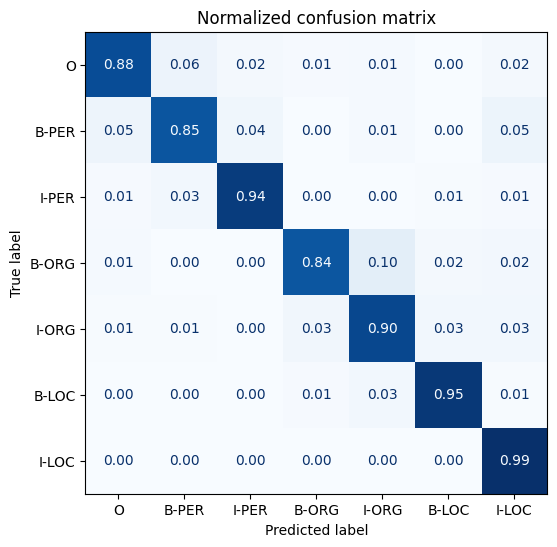

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [54]:
def get_samples(df):
  for _, row in df.iterrows():
    labels, preds, tokens, losses = [], [], [], []
    for i, mask in enumerate(row["attention_mask"]):
      if i not in {0, len(row["attention_mask"])}:
        labels.append(row["labels"][i])
        preds.append(row["predicted_label"][i])
        tokens.append(row["input_tokens"][i])
        losses.append(f"{row['loss'][i]:.2f}")
    df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                          "preds": preds, "losses": losses}).T
    yield df_tmp
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,B-ORG,O,O,I-ORG,O,O,O,O,O,B-ORG,O
losses,0.00,0.00,4.70,0.00,0.00,0.00,10.91,9.95,8.31,6.90,5.92,0.00,7.80,7.39,0.00,8.25,6.55,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,8.67,0.00,0.00,6.30,7.99,8.20,6.26,0.00,8.33,9.04,7.80,7.18,5.10,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,5.96,6.17,5.92,0.00,5.71,0.00,5.58,0.00,5.77,5.73,5.74,5.80,5.32,5.23,0.00


In [55]:
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.02,0.01,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.18,0.00,0.00,0.16,0.13,0.00,0.12,0.00


# Cross lingual transfer

In [56]:
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

In [63]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [ ]:
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer.model, panx_ds["test"])

f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
# print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

In [ ]:
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

In [ ]:
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

# When does zero shot transfer becomes necessary

In [57]:
def train_on_subset(dataset, num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds) // batch_size
  trainer = Trainer(model_init=model_init, args=training_args,
      data_collator=data_collator, compute_metrics=compute_metrics,
      train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  trainer.train()
  if training_args.push_to_hub: trainer.push_to_hub(commit_message="Training completed!")
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [58]:
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

Map:   0%|          | 0/2290 [00:00<?, ? examples/s]

In [59]:
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.812300,1.412583,0.166826
2,1.265100,1.123432,0.146288
3,1.087700,1.028985,0.197620


,num_samples,f1_score
0,250,0.189947


In [1]:
for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

NameError: ignored

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

In [ ]:
from datasets import concatenate_datasets
def concatenate_splits(corpora):
  multi_corpus = DatasetDict()
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets(
        [corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"
trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

In [ ]:
corpora = [panx_de_encoded]
# Exclude German from iteration
for lang in langs[1:]:
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  # Fine-tune on monolingual corpus
  ds_encoded = encode_panx_dataset(panx_ch[lang])
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  # Collect F1-scores in common dict
  f1_scores[lang][lang] = metrics["f1_score"][0]
  # Add monolingual corpus to list of corpora to concatenate
  corpora.append(ds_encoded)

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"
trainer = Trainer(model_init=model_init, args=training_args,
  data_collator=data_collator, compute_metrics=compute_metrics,
  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
  eval_dataset=corpora_encoded["validation"])
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])
scores_data = {"de": f1_scores["de"],
  "each": {lang: f1_scores[lang][lang] for lang in langs},
  "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                        inplace=True)
f1_scores_df